In [1]:
# basic lib
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data 

In [23]:
#def get_data():
df = pd.read_csv('ecommerce_data.csv')
# get sample data
X = df.drop('user_action', axis = 1)
# get target sample data
Y = df['user_action']
df.head() 

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2


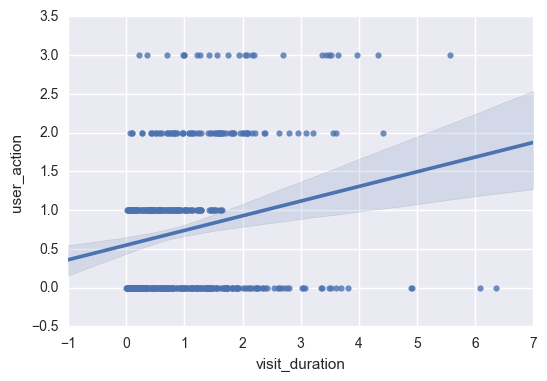

In [29]:
sns.regplot(x="visit_duration", y="user_action", data=df)
#sns.regplot(x="n_products_viewed", y="user_action", data=df)
#sns.boxplot(x="n_products_viewed", y="user_action", data=df);

# Preprocessing

In [3]:
# normalize column n_products_viewed and visit_duration
cols_to_norm = ['n_products_viewed','visit_duration']
X[cols_to_norm] = X[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

X.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day
0,1,-0.816161,-0.407869,0,3
1,1,0.139531,-0.498929,0,2
2,1,-0.816161,-1.037804,1,1
3,1,0.139531,0.618313,1,1
4,0,0.139531,0.981728,1,1


In [4]:
# One-Hot encoding for categorical column time_of_day
one_hot = pd.get_dummies(X['time_of_day'], prefix = 'time_of_day')
X.drop('time_of_day', axis=1, inplace=True)
X = X.join(one_hot)
X.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3
0,1,-0.816161,-0.407869,0,0.0,0.0,0.0,1.0
1,1,0.139531,-0.498929,0,0.0,0.0,1.0,0.0
2,1,-0.816161,-1.037804,1,0.0,1.0,0.0,0.0
3,1,0.139531,0.618313,1,0.0,1.0,0.0,0.0
4,0,0.139531,0.981728,1,0.0,1.0,0.0,0.0


## Wrapping it as a function

In [13]:
def get_data():
    df = pd.read_csv('ecommerce_data.csv')
    # get sample data
    X = df.drop('user_action', axis = 1)
    # get target sample data
    Y = df['user_action']

    # normalize column n_products_viewed and visit_duration
    cols_to_norm = ['n_products_viewed','visit_duration']
    X[cols_to_norm] = X[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

    # One-Hot encoding for categorical column time_of_day
    one_hot = pd.get_dummies(X['time_of_day'], prefix = 'time_of_day')
    X.drop('time_of_day', axis=1, inplace=True)
    X = X.join(one_hot)
    
    return X, Y

    

## Get only binary data for logistic regression training

In [29]:
# get only binary data for logistic regression training
#def get_binary_data():
X, Y = get_data()
Y.describe()

count    500.00000
mean       0.74800
std        0.89336
min        0.00000
25%        0.00000
50%        0.00000
75%        1.00000
max        3.00000
Name: user_action, dtype: float64

In [14]:
X2 = X[Y<=1]
Y2 = Y[Y<=1]
Y2.describe() 

count    398.000000
mean       0.364322
std        0.481845
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: user_action, dtype: float64

## ...as a funtion

In [15]:
def get_binary_data():
    X, Y = get_data()
    X2 = X[Y<=1]
    Y2 = Y[Y<=1]
    
    return X2, Y2 

# Making prediction

In [45]:
X, Y =  get_data()
X = X.as_matrix()
Y = Y.as_matrix()

# hidden units
M = 5
# no. features
D = X.shape[1] 

# no. unique values on Y
K = len(set(Y))

# layer 1 weights and bias
W1 = np.random.randn(D, M) 
b1 = np.zeros(M)
# layer 2 weights and bias
W2 = np.random.randn(M, K)
b2 = np.zeros(K)



Softmax 
$$f_j(z) = \frac{e^{z_j}}{\sum_k e^{z_k}}$$

Forward propagation
$$f(x_i, W, b) =  W x_i + b$$

In [46]:
def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

# Predicting probability based on initialized weights
def forward(X, W1, b1, W2, b2):
    # activation function
    Z = np.tanh(X.dot(W1)+b1)
    return softmax(Z.dot(W2)+b2)

# calculate probability for each class
P_Y_given_X = forward(X, W1, b1, W2, b2) 
#print(P_Y_given_X)

# pick highest probability
predictions = np.argmax( P_Y_given_X, axis=1)
#print(predictions)

# calculate the accuracy
def classification_rate(Y, P):
    return np.mean(Y == P)

print( "Score:", classification_rate(Y, predictions))

Score: 0.264


# Training and testing ANN
1. Initialize weights

2. Calculate Cost: difference between Y and Y_hat ( the prediction of Y)<br>
    Cost - Cross entropy cost function
    
3. Minimize Cost<br>
    Can use Gradient descent if function is convex(avoiding local minima)<br>
cost(hθ, (x),y) = -ylog( hθ(x) ) - (1-y)log( 1- hθ(x) ) 

In [52]:
from sklearn.utils import shuffle

def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

X, Y = get_data()
X, Y = shuffle(X, Y)
X = X.as_matrix()
Y = Y.as_matrix()

M = 5
D = X.shape[1]
K = len(set(Y))

# create train and test sets
Xtrain = X[:-100]
Ytrain = Y[:-100]
Ytrain_ind = y2indicator(Ytrain, K)

Xtest = X[-100:]
Ytest = Y[-100:]
Ytest_ind = y2indicator(Ytest, K)

# randomly initialize weights
W1 = np.random.randn(D, M)
b1 = np.zeros(M)
W2 = np.random.randn(M, K)
b2 = np.zeros(K)

def softmax(a):
    expA = np.exp(a)
    return expA / expA.sum(axis=1, keepdims=True)

# Calculate probability based on initialized weights
def forward(X, W1, b1, W2, b2):
    # activation function 
    Z = np.tanh(X.dot(W1)+b1) #hidden units
    return softmax(Z.dot(W2)+b2), Z

def predict(P_Y_given_X): 
    return np.argmax( P_Y_given_X, axis=1)

# calculate the accuracy
def classification_rate(Y, P):
    return np.mean(Y == P)

def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY))

0 0.514799430084 0.526590087021
1000 0.0224905113846 0.0289414762163
2000 0.0153235668534 0.024301872565
3000 0.012580815294 0.0242485914696
4000 0.0108269100286 0.023966132698
5000 0.00939344100372 0.0234135975224
6000 0.00830770429822 0.0233711490652
7000 0.00758332153343 0.0237659627059
8000 0.00706632497503 0.0242005611798
9000 0.00666517191653 0.0245247328726
Final train classification_rate: 0.9925
Final test classification_rate: 0.97


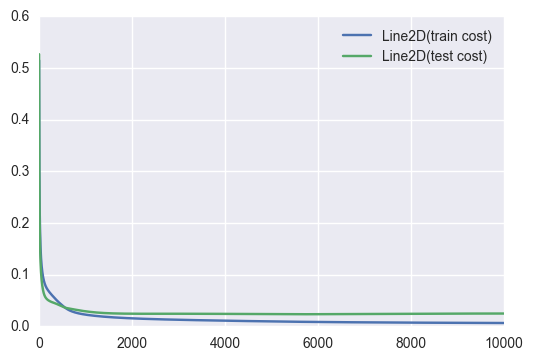

In [54]:
# train loop
train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10000):
    pYtrain, Ztrain = forward(Xtrain, W1, b1, W2, b2)
    pYtest, Ztest = forward(Xtest, W1, b1, W2, b2)

    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    train_costs.append(ctrain)
    test_costs.append(ctest)

    # gradient descent
    W2 -= learning_rate*Ztrain.T.dot(pYtrain - Ytrain_ind)
    b2 -= learning_rate*(pYtrain - Ytrain_ind).sum(axis=0)
    dZ = (pYtrain - Ytrain_ind).dot(W2.T) * (1 - Ztrain*Ztrain)
    W1 -= learning_rate*Xtrain.T.dot(dZ)
    b1 -= learning_rate*dZ.sum(axis=0)
    
    if i % 1000 == 0:
        print (i, ctrain, ctest)

print ("Final train classification_rate:", classification_rate(Ytrain, predict(pYtrain)))
print ("Final test classification_rate:", classification_rate(Ytest, predict(pYtest)))

legend1, = plt.plot(train_costs, label='train cost')
legend2, = plt.plot(test_costs, label='test cost')
plt.legend([legend1, legend2])
plt.show()